In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [145]:
raw_data = pd.read_csv("data/FlightPath.csv", header=None)
raw_data

,0,1
0,0.000000,1.000000
1,12.872340,3.622990
2,1.000000,1.000000
3,13.910740,4.694889
4,2.000000,1.000000
...,...,...
63,7.718620,6.381560
64,32.000000,1.000000
65,6.848592,5.578642
66,33.000000,1.000000


In [146]:
csv_index = pd.Index(raw_data[0][::2], dtype='int', name="Scan")
csv_index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
            33],
           dtype='int64', name='Scan')

In [147]:
scan_coords = pd.DataFrame(raw_data[1::2])
scan_coords.columns=['X', 'Y']
scan_coords.index = csv_index
scan_coords

,X,Y
Scan,,
0,12.872340,3.622990
1,13.910740,4.694889
2,14.912220,5.696368
3,15.982300,6.766453
4,16.682690,7.500103
5,17.185110,8.036117
6,17.185110,9.204402
7,17.155300,10.234630
8,17.155300,11.243450


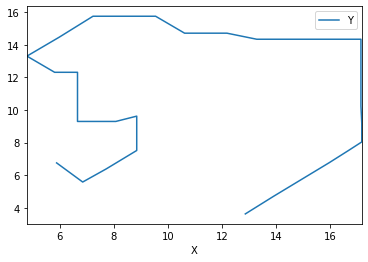

In [148]:
ax1 = scan_coords.plot(x='X', y='Y')

In [149]:
#Read csv and process iteratively

import csv
from collections import defaultdict

dic = defaultdict(list)

with open("data/LIDARPoints.csv", "r") as f:
    reader = csv.reader(f, delimiter=",")
    read_sweep_data = True
    n_sweep_in_scan = 0
    current_sweep = 99999
    current_scan = 0
    for i, line in enumerate(reader):
        if current_sweep < n_sweep_in_scan:             
            #append
            #print(i, line, current_scan)
            dic["Scan"].append(current_scan)
            dic["Angle"].append(float(line[0]))
            dic["Distance"].append(float(line[1]))
            current_sweep += 1
        else:
            current_scan = int(line[0])
            n_sweep_in_scan = int(line[1])
            current_sweep = 0

In [150]:
obstacle_data = pd.DataFrame(dic)
obstacle_data

,Scan,Angle,Distance
0,0,1.096680,8964.0
1,0,1.771484,8967.0
2,0,2.446777,8970.0
3,0,3.121582,8976.0
4,0,3.796875,8982.0
...,...,...,...
18126,33,357.600100,3986.0
18127,33,358.274900,3985.0
18128,33,358.949700,3984.0
18129,33,359.625000,3983.0


In [151]:
obstacle_data_coords = obstacle_data.join(other=scan_coords, on="Scan")

In [152]:
obstacle_data_coords['X'] = obstacle_data_coords['X'] + ((obstacle_data_coords['Distance'] / 1000) * np.cos(np.radians(obstacle_data_coords['Angle'])))
obstacle_data_coords['Y'] = obstacle_data_coords['Y'] - ((obstacle_data_coords['Distance'] / 1000) * np.sin(np.radians(obstacle_data_coords['Angle'])))

AttributeError: 'Line2D' object has no property 's'

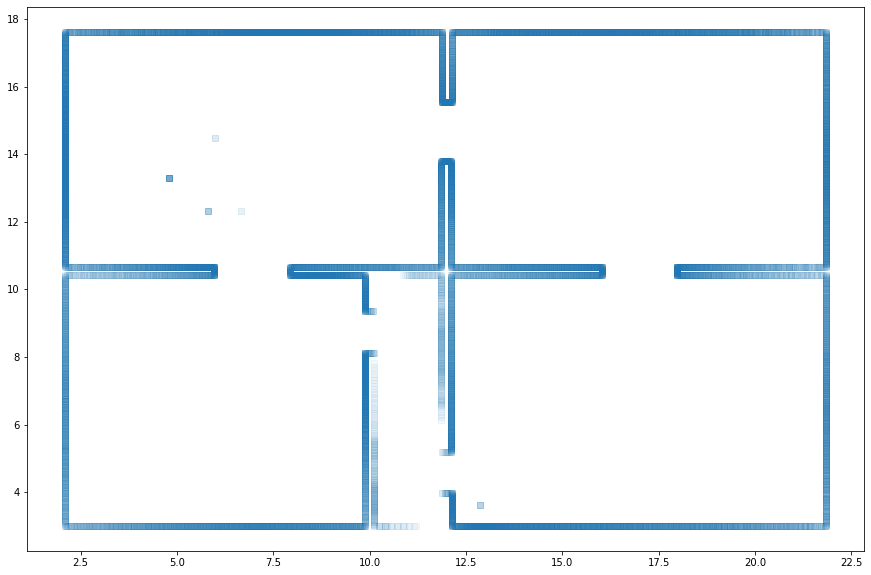

In [161]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)

ax1.scatter(obstacle_data_coords['X'], obstacle_data_coords['Y'], marker="s", label='obstacle', alpha=0.05)
ax1.plot(scan_coords['X'], scan_coords['Y'], marker="o", label='path', color="orange", s="ok-")


plt.show()